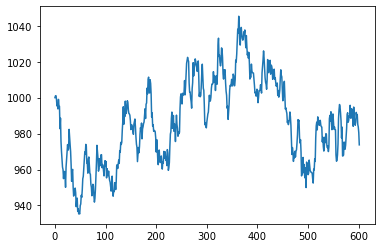

In [33]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from DataHandler import DataHandler
from TradingEnv import TradingEnvironment

# dynamics params
X_0 = 100000
q = 5000
F_0 = 1000 # init price
rho = 2.2231
lambda_ = 1/(2*q)
T = 1
N = 600
timestamps = list(range(0, N+1))#[n*T/N for n in range(0,N+1)]

def get_random_walk(scale_param = 5):
    P = F_0
    F = [P]
    for i in range(N+1):
        P += np.random.normal(0, 1)*scale_param
        F.append(P)
    return F
F = get_random_walk()
plt.plot(F)
data = pd.Series(F)

env = TradingEnvironment(data, len(data))
    

In [34]:
state = env.reset()
a = 0
rewards = 0
for i in range(len(data)):
    #print('Step:', env.simulator.step)
    state, reward, info, done = env.step(1)
    rewards += reward
    #print('reward:', info[i])
print(rewards/len(data))
    

-324180100.41183513


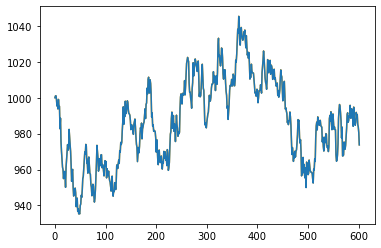

In [35]:
plt.plot(info, color='orange')
plt.plot(data)

In [36]:
import numpy as np
from agent import Agent

from collections import deque

# Create simulation environment
episodes = 10
# Initialize Feed-forward DNNs for Actor and Critic models. 
agent = Agent(state_size=3, action_size=1,random_seed = 1234)
agent.reset()
for episode in range(episodes): 
    # Reset the enviroment
    cur_state = env.reset()

    # set the environment to make transactions
    avg_rewards = 0
    for i in range(len(data)):
      
        # Predict the best action for the current state.
        action = float(agent.act(cur_state, add_noise = True))
        #print(action1,action2)
        # Action is performed and new state, reward, info are received. 
        new_state, reward, info, done = env.step(action*env.simulator.inventory)
        #print('reward', reward)
        avg_rewards += reward
        #print(new_state)
        # current state, action, reward, new state are stored in the experience replay 
        agent.step(cur_state, action, reward, new_state, done)
        # roll over new state
        cur_state = new_state
        if done == True:
            print('Episode', episode, '|| Avg reward:', avg_rewards/len(data))
            break

Episode 0 || Avg reward: -99513212.18449733
Episode 1 || Avg reward: -99513212.18449733
Episode 2 || Avg reward: -99513212.18449733
Episode 3 || Avg reward: -6946641.08453449
Episode 4 || Avg reward: -167633.4935878718
Episode 5 || Avg reward: -167661.35436829596
Episode 6 || Avg reward: -167713.53594000364
Episode 7 || Avg reward: -167520.9743817672
Episode 8 || Avg reward: -167572.3075888746
Episode 9 || Avg reward: -167677.86136564717


In [53]:
print('Average cost (RL):', np.mean(env.simulator.strategy_costs))
print('Total cost (RL):', np.sum(env.simulator.strategy_costs))

Average cost (RL): -167677.86136564708
Total cost (RL): -100942072.54211955


Text(0, 0.5, 'trades sizes')

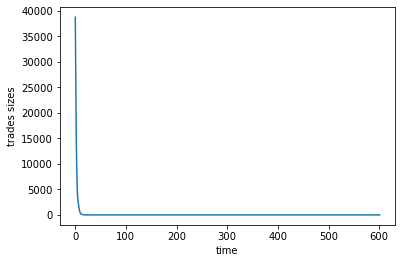

In [37]:
plt.plot(env.simulator.actions)
plt.xlabel('time')
plt.ylabel('trades sizes')
#plt.plot(obizhaeva())

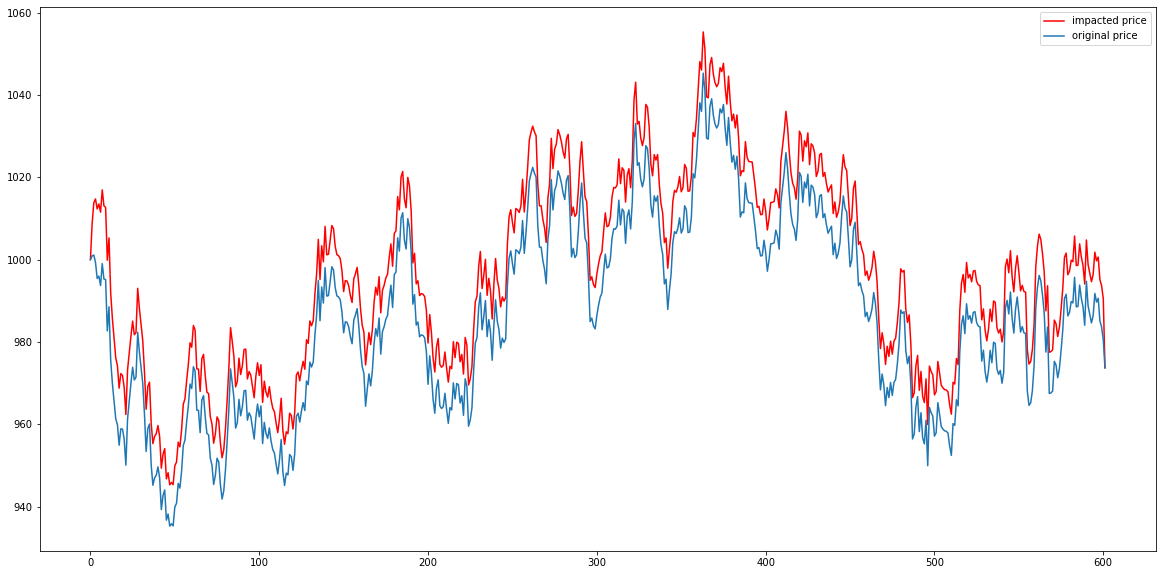

In [38]:
plt.figure(figsize = (20, 10))
plt.plot(info, color='red', label='impacted price')
plt.plot(data, label = 'original price')
plt.legend()

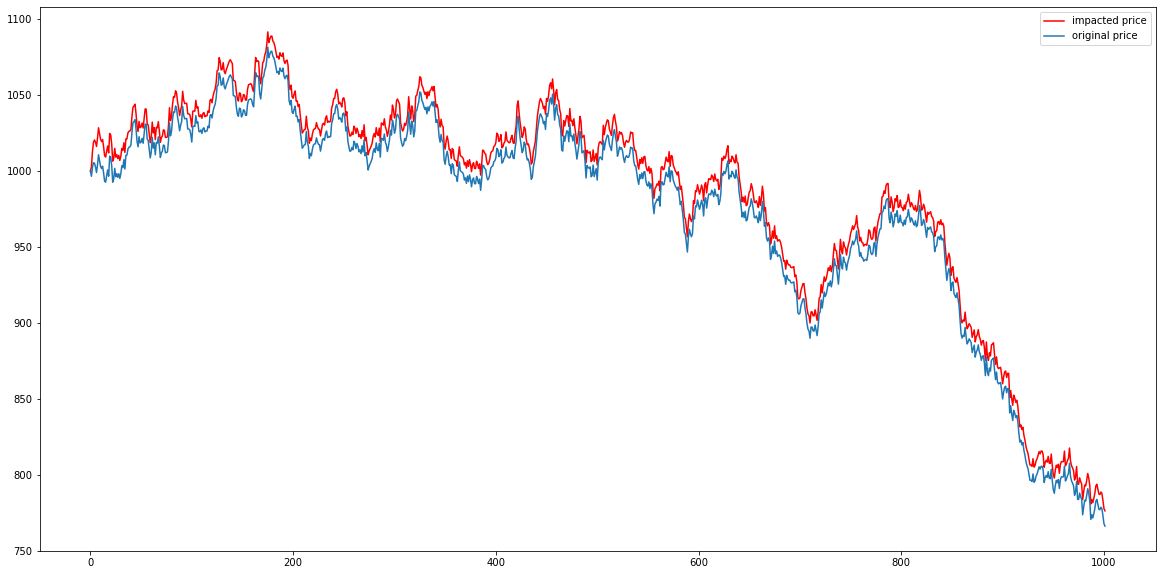

In [24]:
plt.figure(figsize = (20, 10))
plt.plot(info, color='red', label='impacted price')
plt.plot(data, label = 'original price')
plt.legend()

In [39]:
env2 = TradingEnvironment(data, len(data))

state = env2.reset()
a = 0
for i in range(len(data)):
    if i == 0 or i == len(data)-2:
        a = X_0/(rho*T + 2)
        state, reward, info, done = env2.step(a)
    else:
        a = rho*X_0/(rho*T+2)/(len(data)-3)
        state, reward, info, done = env2.step(a)
    

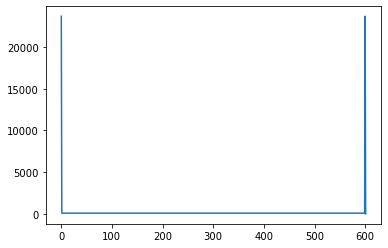

In [44]:
plt.plot(env2.simulator.actions)
#plt.plot(env.simulator.actions)

In [54]:
print('Average cost:', np.mean(env2.simulator.strategy_costs))
print('Total cost:', np.sum(env2.simulator.strategy_costs))

print('Average cost (RL):', np.mean(env.simulator.strategy_costs))
print('Total cost (RL):', np.sum(env.simulator.strategy_costs))

print('diff costs:', np.sum(env.simulator.strategy_costs) - np.sum(env2.simulator.strategy_costs))

Average cost: -165101.0153626464
Total cost: -99390811.24831313
Average cost (RL): -167677.86136564708
Total cost (RL): -100942072.54211955
diff costs: -1551261.2938064188


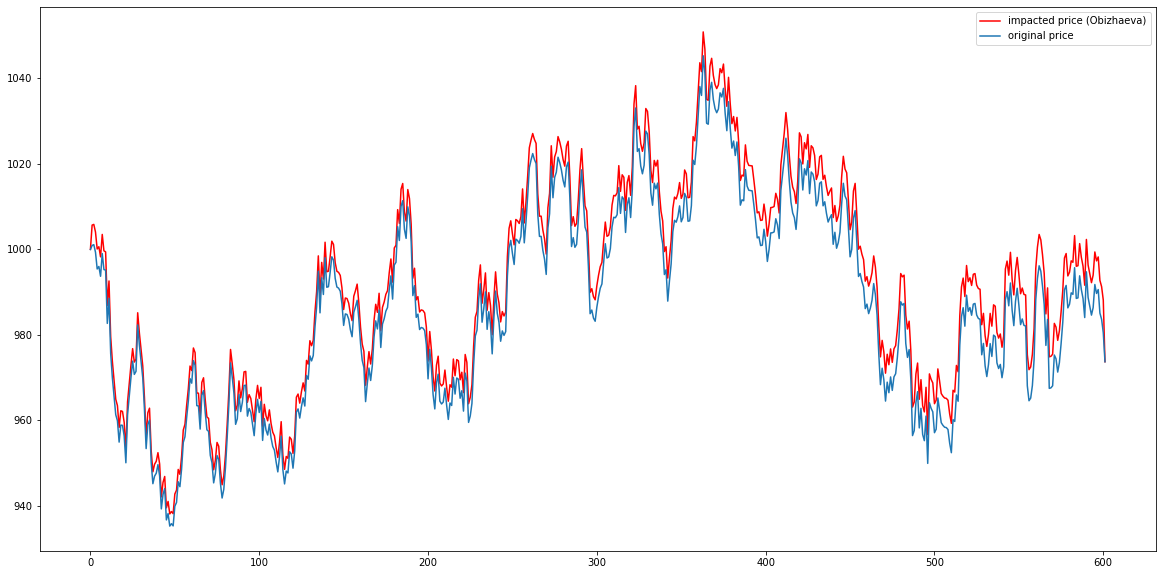

In [41]:
plt.figure(figsize = (20, 10))
plt.plot(info, color='red', label='impacted price (Obizhaeva)')
plt.plot(data, label = 'original price')
plt.legend()

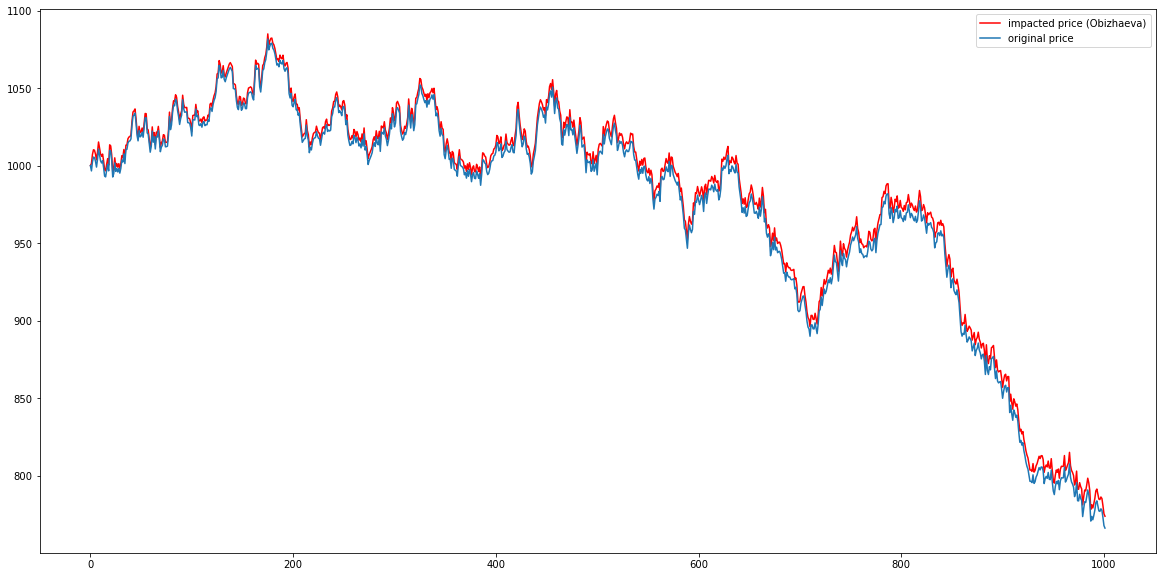

In [35]:
plt.figure(figsize = (20, 10))
plt.plot(info, color='red', label='impacted price (Obizhaeva)')
plt.plot(data, label = 'original price')
plt.legend()